In [1]:
import yfinance as yf 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
tickers = ['BTC-USD', 'ETH-USD']
df = yf.download(tickers, start='2020-01-01', end='2024-12-31')
df = df['Close'].dropna()
df = df.rename(columns={'BTC-USD':'Bitcoin', 'ETH-USD':'Ether'})
df_returns = df.pct_change().dropna()

C:\Users\arthu\AppData\Local\Temp\ipykernel_16940\2902556558.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  2 of 2 completed


In [3]:
vol_btc = df_returns['Bitcoin'].std()
vol_ann_btc = vol_btc*np.sqrt(252)

vol_eth = df_returns['Ether'].std()
vol_ann_eth = vol_eth*np.sqrt(252)

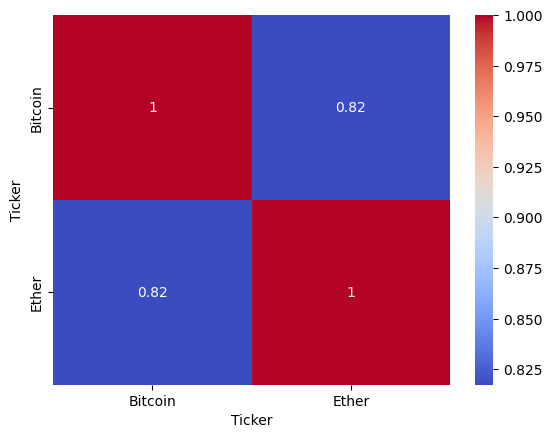

In [4]:
corr_matrix = df_returns.corr()
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [5]:
cum_returns = (1+df_returns).cumprod()
running_max = cum_returns.cummax()
drawdown = (cum_returns - running_max)/running_max
MDD = drawdown.min()

In [6]:
weights = np.array([0.8,0.2])
df_returns['Portfolio'] = df_returns@weights

In [7]:
rolling_vol = df_returns['Portfolio'].rolling(window=75).std()
mean_vol = rolling_vol.mean()
std_rolling_vol = rolling_vol.std()

In [8]:
signal = np.where(rolling_vol > mean_vol + std_rolling_vol, 1, np.where(rolling_vol < mean_vol - std_rolling_vol, -1,0))

signal = pd.Series(signal, index=df_returns.index)
signal = signal.shift(1)

In [9]:
strategy_returns = signal*df_returns['Portfolio']

cum_strategy = (1+strategy_returns).cumprod()
cum_portfolio = (1+df_returns['Portfolio']).cumprod()

running_strat_max = cum_strategy.cummax()
drawdown_strat = (cum_strategy - running_strat_max)/running_strat_max
MDD_strat = drawdown_strat.min()

running_market_max = cum_portfolio.cummax()
drawdown_market = (cum_portfolio - running_market_max)/running_market_max
MDD_market = drawdown_market.min()

total_strategy = cum_strategy.iloc[-1] - 1
total_hold = cum_portfolio[-1] - 1

print(f"Performance strategy : {total_strategy:.2%}")
print(f"Performance buy & hold : {total_hold:.2%}")
print(f"Max Drawdown strategy : {MDD_strat:.2%}")
print(f"Max Drawdown buy & hold : {MDD_market:.2%}")

Performance strategy : 195.45%
Performance buy & hold : 1514.47%
Max Drawdown strategy : -45.99%
Max Drawdown buy & hold : -76.36%


C:\Users\arthu\AppData\Local\Temp\ipykernel_16940\1823612062.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_hold = cum_portfolio[-1] - 1


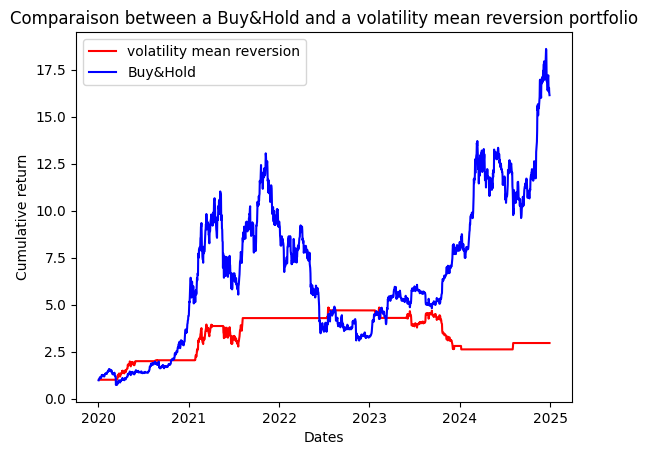

In [10]:
#Visualisation 
plt.figure()
plt.plot(df_returns.index, cum_strategy, color='red', label='volatility mean reversion')
plt.plot(df_returns.index, cum_portfolio, color='blue', label='Buy&Hold')
plt.xlabel('Dates')
plt.ylabel('Cumulative return')
plt.title('Comparaison between a Buy&Hold and a volatility mean reversion portfolio')
plt.legend()
plt.show()